# REMCMC benchmark

エネルギーが
$$f(x)=\frac12\sum_{i=1}^d (x_i^4-16x_i^2+5x_i)$$
の関数(["STYBLINSKI-TANG FUNCTION"](https://www.sfu.ca/~ssurjano/stybtang.html))のサンプリング

大域最小解は
$$f(x^*)=-39.16599d,\; \text{at}\; x^*=(-2.9035,\dots,-2.9035)$$
$\{-2.9035, 2.74680\}^d$の複数地点で極小値があり，局所最適化では大域解を求めづらい関数．

$d=3$次元でテスト．
```bash
$ python remcmc_bench.py > sampling_log.txt
```
で通常のM-HアルゴリズムとReplica Exchangeでのサンプリング結果を`test_mhmcmc_*.bin`と`test_remcmc_*.bin`に保存．  
※どちらも $(2,2,2)$ 付近からサンプリング開始

In [1]:
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## M-Hアルゴリズム

In [2]:
with open(glob.glob("test_mhmcmc_*.bin")[0], mode="rb") as file:
    data = pickle.load(file)

In [3]:
data.keys()

dict_keys(['param_name_j', 'beta_k', 'eps_j_k', 'exchange_step', 'accept_j_n_k', 'exchange_accept_n_k', 'sample_j_n_k', 'lcp_sample_n_k', 'lpp_sample_n_k', 'll_sample_n_k'])

In [4]:
sample_j_n_k = np.array(data["sample_j_n_k"])

In [5]:
burnin = 100
skip = 3

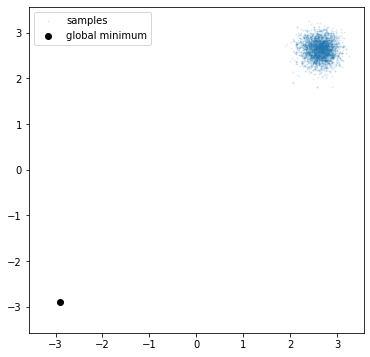

In [6]:
plt.figure(figsize=(6,6))
plt.scatter(
    sample_j_n_k[0, burnin::skip, 0],
    sample_j_n_k[0, burnin::skip, 1],
    s=1, alpha=0.1, label="samples"
)
plt.scatter([-2.903534], [-2.903534], c="k", label="global minimum")
lim = abs(np.array([*plt.xlim(), *plt.ylim()])).max()
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.legend()
plt.show()

$(2.74680, 2.74680, 2.74680)$付近にトラップされて抜け出せていない．

## REMCMC

In [7]:
with open(glob.glob("test_remcmc_*.bin")[0], mode="rb") as file:
    data = pickle.load(file)

sample_j_n_k = np.array(data["sample_j_n_k"])

k0 = abs(np.log10(data["beta_k"])).argmin()
burnin = 100
skip = 3

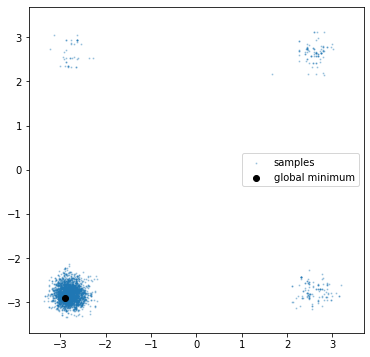

In [8]:
plt.figure(figsize=(6,6))
plt.scatter(
    sample_j_n_k[k0, burnin::skip, 0],
    sample_j_n_k[k0, burnin::skip, 1],
    s=1, alpha=0.3, label="samples"
)
plt.scatter([-2.903534], [-2.903534], c="k", label="global minimum")
lim = abs(np.array([*plt.xlim(), *plt.ylim()])).max()
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.legend()
plt.show()

全体をサンプリングできている

In [9]:
data["beta_k"]

array([1.00000000e-07, 3.16227766e-07, 1.00000000e-06, 3.16227766e-06,
       1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])

In [10]:
burnin = 100
skip = 3

$\beta$ による分布の変化

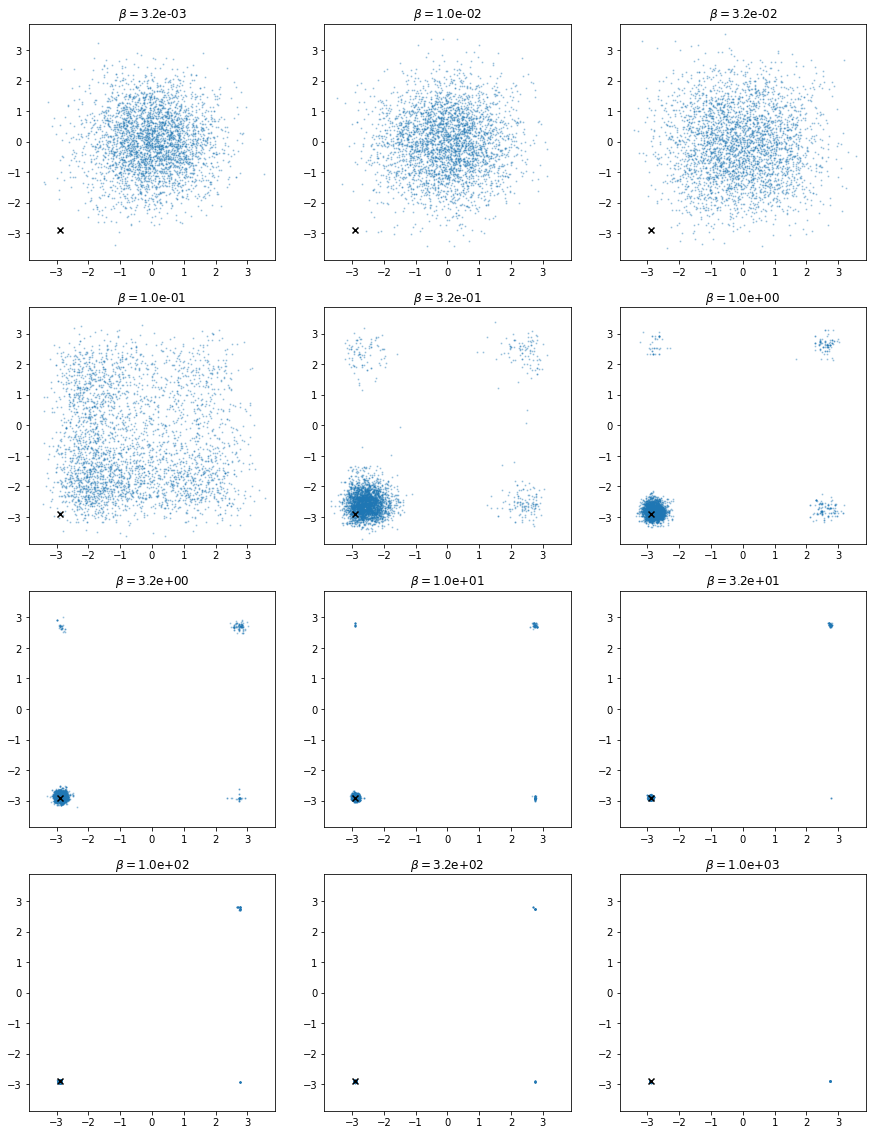

In [11]:
lim=abs(sample_j_n_k[0,burnin::skip,:]).max()
fig, axes = plt.subplots(
    figsize=(5*3, 5*4),
    nrows=4, ncols=3,
    sharex=False)
for k,beta in enumerate(data["beta_k"]):
    if k<9:continue
    axes[k//3-3, k%3].scatter(
        sample_j_n_k[k, burnin::skip, 0],
        sample_j_n_k[k, burnin::skip, 1],
        s=1, alpha=0.3, label="samples"
    )
    axes[k//3-3, k%3].scatter([-2.903534], [-2.903534], c="k", marker="x", label="global minimum")
    axes[k//3-3, k%3].set_xlim(-lim, lim)
    axes[k//3-3, k%3].set_ylim(-lim, lim)
    axes[k//3-3, k%3].set_title(r"$\beta=$"f"{beta:.1e}")
    #axes[k//3-2, k%3].legend(loc="upper left")
plt.show()

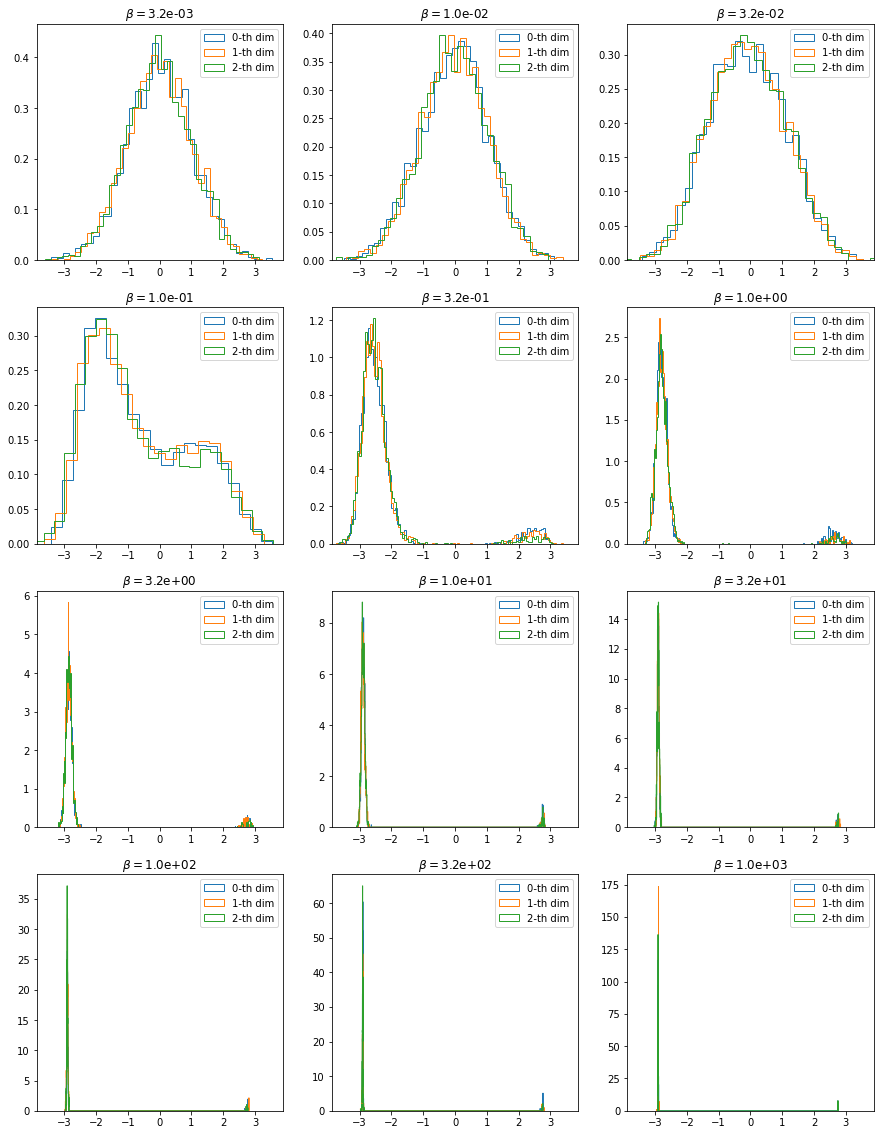

In [12]:
lim=abs(sample_j_n_k[0,burnin::skip,:]).max()
fig, axes = plt.subplots(
    figsize=(5*3, 5*4),
    nrows=4, ncols=3,
    sharex=False)
for k,beta in enumerate(data["beta_k"]):
    if k<9:continue
    for d in range(3):
        axes[k//3-3, k%3].hist(
            sample_j_n_k[k, burnin::skip, d],
            bins="auto", density=True, histtype="step",
            label=f"{d}-th dim"
        )
    axes[k//3-3, k%3].set_xlim(-lim, lim)
    axes[k//3-3, k%3].set_ylim(0, )
    axes[k//3-3, k%3].legend(loc="upper right")
    axes[k//3-3, k%3].set_title(r"$\beta=$"f"{beta:.1e}")
plt.show()

$\beta=10^3$ ではほぼ大域解に集中している

In [13]:
for d in range(3):
    print(f"{sample_j_n_k[-1,burnin::skip,d][(sample_j_n_k[-1,burnin::skip,:]<0).all(axis=-1)].mean():.4f}"\
          f"±{sample_j_n_k[-1,burnin::skip,d][(sample_j_n_k[-1,burnin::skip,:]<0).all(axis=-1)].std():.4f}")

-2.9033±0.0059
-2.9037±0.0067
-2.9040±0.0063
